In [1]:
import numpy as np

# File paths
mha_file_path = 'displacement_field.mha'
raw_file_path = 'displacement_field.raw'

# Step 1: Create the raw displacement field data (256x256 image with 2D vectors)
# Each pixel has two float values representing the displacement in x and y directions
displacement_field = np.zeros((256, 256, 2), dtype=np.float32)

# Optionally, modify the displacement field values here (for example, simple scaling):
for i in range(256):
    for j in range(256):
        displacement_field[i, j, 0] = j*0.1  # X-direction displacement
        displacement_field[i, j, 1] = j*0.2  # Y-direction displacement

# Step 2: Save the displacement field as a binary raw file
displacement_field.tofile(raw_file_path)

# Step 3: Create the corresponding .mha file
with open(mha_file_path, 'w') as mha_file:
    mha_file.write('ObjectType = Image\n')
    mha_file.write('NDims = 2\n')
    mha_file.write('BinaryData = True\n')
    mha_file.write('BinaryDataByteOrderMSB = False\n')
    mha_file.write('CompressedData = False\n')
    mha_file.write('TransformMatrix = 1 0 0 1\n')
    mha_file.write('Offset = 0 0\n')
    mha_file.write('CenterOfRotation = 0 0\n')
    mha_file.write('DimSize = 256 256\n')
    mha_file.write('ElementSpacing = 1 1\n')
    mha_file.write('ElementNumberOfChannels = 2\n')
    mha_file.write('ElementType = MET_FLOAT\n')
    mha_file.write(f'ElementDataFile = {raw_file_path}\n')

print(f"Successfully created '{mha_file_path}' and '{raw_file_path}'")


# Create a 256x256 displacement field with two channels (for 2D displacement)
field = np.zeros(displacement_field.shape, dtype=np.float32)

# Optionally, modify the field to add some displacement
for i in range(256):
    for j in range(256):
        field[i, j, 0] = 0  # x-direction displacement
        field[i, j, 1] = 0  # y-direction displacement

# Save as a raw binary file
field.tofile('displacement_field.raw')

#for i in range(256):
#    for j in range(256):
#        assert field[i, j, 0] == j*0.1  # Confirm x-direction displacement is 0
#        assert field[i, j, 1] == 0  # Confirm y-direction displacement is 0


Successfully created 'displacement_field.mha' and 'displacement_field.raw'


In [2]:
import itk

input_image_path = 'Brain_CT.jpg'  # Input image (e.g., grayscale or RGB)
input_displacement_field_path = 'displacement_field.mha'  # Displacement field file
output_image_path = 'output_image.png'
Dimension = 2

# Define the pixel and image types
VectorComponentType = itk.F  # 'float' as specified in the .mha file
VectorPixelType = itk.Vector[VectorComponentType, Dimension]
DisplacementFieldType = itk.Image[VectorPixelType, Dimension]

PixelType = itk.UC  # If your input image is grayscale, use 'unsigned char'
ImageType = itk.Image[PixelType, Dimension]

# Read the input image and displacement field
image_reader = itk.ImageFileReader[ImageType].New()
image_reader.SetFileName(input_image_path)

field_reader = itk.ImageFileReader[DisplacementFieldType].New()
field_reader.SetFileName(input_displacement_field_path)

# Update the displacement field reader to get the output
field_reader.Update()
deformation_field = field_reader.GetOutput()

# Set up the warp image filter
warp_filter = itk.WarpImageFilter[ImageType, ImageType, DisplacementFieldType].New()

# Set the interpolator (linear interpolation)
interpolator = itk.LinearInterpolateImageFunction[ImageType, itk.D].New()
warp_filter.SetInterpolator(interpolator)

# Set the deformation field
warp_filter.SetDisplacementField(deformation_field)

# Set the output image properties
warp_filter.SetOutputSpacing(deformation_field.GetSpacing())
warp_filter.SetOutputOrigin(deformation_field.GetOrigin())
warp_filter.SetOutputDirection(deformation_field.GetDirection())

# Set the input image
warp_filter.SetInput(image_reader.GetOutput())

# Write the warped image to a file
writer = itk.ImageFileWriter[ImageType].New()
writer.SetFileName(output_image_path)
writer.SetInput(warp_filter.GetOutput())

try:
    writer.Update()
    print(f"Image successfully warped and written to {output_image_path}")
except itk.ExceptionObject as e:
    print(f"Exception caught during processing: {e}")


Image successfully warped and written to output_image.png


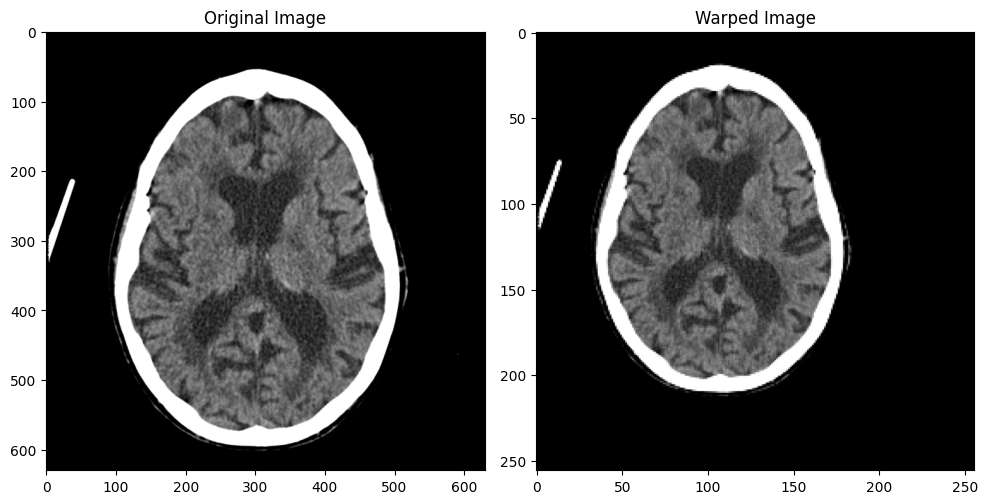

In [3]:
# plot the original and warped images
import matplotlib.pyplot as plt

# Read the original and warped images
original_image = itk.imread(input_image_path)
warped_image = itk.imread(output_image_path)

# Plot the original and warped images side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(itk.array_from_image(original_image), cmap='gray')
plt.title('Original Image')
plt.axis('on')

plt.subplot(1, 2, 2)
plt.imshow(itk.array_from_image(warped_image), cmap='gray')
plt.title('Warped Image')
plt.axis('on')

plt.tight_layout()
plt.show()